## [Project2] ADAS
* 0. 실습 환경 설정
* 1. 데이터 준비하기 - Object Detection
    * 1-1. 데이터셋 이름 변경하기
    * 1-2. Pascal VOC Format to YOLO Format
    * 1-3. Train / Test 분리하기
    * 1-4. Config file 만들기
* 2. 데이터 준비하기 - Semantic Segmentation
    * 2-1. 데이터셋 다운로드
    * 2-2. Segmentation Map 수정하기
    * 2-3. 데이터셋 이름 변경하기
    * 2-4. 데이터셋 샘플 보기
* 3. Object Detection
    * 2-1. Training
    * 2-2. Testing
* 4. Lane Detection - Semantic Segmentation
    * 4-1. Training
    * 4-2. Inference
* 5. Lane Detection - Hough Transform
    * 5-1. 필요한 함수 정의
    * 5-2. Linde Detection Function
* 6. Inference
    * 6-1. Object Detection + Lane Detection(Hough Transform)
    * 6-2. Object Detection + Lane Detection(Semantic Segmentation)

### 0. 실습 환경 설정
* 가상환경명 : adas
* Python 버전 : python 3.7
* 설치 목록
    * !pip3 install --upgrade --no-cache-dir gdown
    * !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
    * !pip install -r requirements.txt
    * albumentations
        * !pip uninstall albumentations
        * !pip install albumentations==0.5.1
    * !pip install ultralytics
    * !pip install opencv-python
    * !pip install matplotlib
    * !pip install pandas

* Unet++ Git 주소: https://github.com/4uiiurz1/pytorch-nested-unet

In [ ]:
#!git clone https://github.com/4uiiurz1/pytorch-nested-unet

In [1]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.145  Python-3.7.16 torch-1.7.1+cu110 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
Setup complete  (12 CPUs, 15.8 GB RAM, 136.4/200.0 GB disk)


### 1. 데이터 준비하기 - Object Detection
### 1-1. 데이터셋 이름 변경하기

* TODO : 경로 이동 (project_adas/data 폴더 생성)

In [ ]:
cd

* TODO : AI-HUB `차량 및 사람 인지 영상`에서 다운로드 [링크](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=195)
    * 선택 다운로드 :    
    Training/바운딩박스/서울특별시/[원천]서울특별시_FLRR_1_01.zip   - 압축풀어서 이미지를 img폴더에   
    Training/바운딩박스/서울특별시/[라벨]서울특별시_FLRR_1_01.zip   - 압축풀어서 라벨파일들을 label폴더에 넣어줌   

In [2]:
import os
import shutil

city = ['서울특별시']
gu = ['영등포구', '종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구','은평구', \
  '서대문구', '마포구', '양천구', '강서구', '구로구','금천구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']
weather = ['맑음']
gan = ['주간', '야간']
sil = ['실내', '실외']

In [3]:
root_folder = 'label'
change_folder = 'labels'

if not os.path.exists(change_folder):
      os.makedirs(change_folder)

file_list = os.listdir(root_folder)
for file in file_list:
  name, ext = file.split('.')
  p = name.split("_")
  p[1] = str(city.index(p[1]))
  p[3] = f"{gu.index(p[3]):02d}"
  p[4] = str(weather.index(p[4]))
  p[5] = str(gan.index(p[5]))
  p[6] = str(sil.index(p[6]))
  new_name = "_".join(p) + '.' + ext
  shutil.copyfile(os.path.join(root_folder, file), os.path.join(change_folder, new_name))


In [4]:
root_folder = 'img'
change_folder = 'images'

if not os.path.exists(change_folder):
      os.makedirs(change_folder)

file_list = os.listdir(root_folder)
for file in file_list:
  name, ext = file.split('.')
  p = name.split("_")
  p[1] = str(city.index(p[1]))
  p[3] = f"{gu.index(p[3]):02d}"
  p[4] = str(weather.index(p[4]))
  p[5] = str(gan.index(p[5]))
  p[6] = str(sil.index(p[6]))
  new_name = "_".join(p) + '.' + ext
  shutil.copyfile(os.path.join(root_folder, file), os.path.join(change_folder, new_name))

### 1-2. Pascal VOC Format to YOLO Format

In [5]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = float(((bbox[2] + bbox[0]) / 2) / w)
    y_center = float(((bbox[3] + bbox[1]) / 2) / h)
    width = float((bbox[2] - bbox[0]) / w)
    height = float((bbox[3] - bbox[1]) / h)
    return [x_center, y_center, width, height]

In [6]:
import json

label_folder = './labels/'
new_folder = './new_labels/'

if not os.path.isdir(new_folder):
    os.mkdir(new_folder)

classes = ['car', 'pedestrian']
cars = ['일반차량', '목적차량(특장차)', '이륜차']
label_list = os.listdir(label_folder)
for file in label_list:
    with open(os.path.join(label_folder, file), 'r') as json_file:
        lab = json.load(json_file)
        h = int(lab['camera']['resolution_height'])
        w = int(lab['camera']['resolution_width'])
        f = open(os.path.join(new_folder, file[:-4]+'txt'),'a')
        for l in lab['annotations']:
            if l['label'] in cars or l['label'] == '보행자':
                if l['label'] in cars: 
                    idx = 0
                else:
                    idx = 1
                points = l['points']
                yolo_bbox = xml_to_yolo_bbox([int(points[0][0]), int(points[0][1]), int(points[2][0]), int(points[2][1])], w,h)
                bbox_string = " ".join([str(x) for x in yolo_bbox])
                result = f"{idx} {bbox_string}\n"
                f.write(result)
        f.close()    

### 1-3. Train / Test 분리하기

In [12]:
import os
import shutil
if os.path.isdir('./train'):
    shutil.rmtree('./train')
if os.path.isdir('./val'):    
    shutil.rmtree('./val')

folder_list = ['train', 'val', 'train/images', 'train/labels', 'val/images', 'val/labels']
for folder in folder_list:
    if not os.path.isdir(folder):
        os.mkdir(folder)

* TODO : `root_folder`를 project_adas/data 폴더로 설정

In [13]:
import random
import shutil
random.seed(2020)

root_folder = 
file_folder = 'new_labels'

file_list = os.listdir(file_folder)
random.shuffle(file_list)
test_ratio = 0.1

val_list = file_list[:int(len(file_list)*test_ratio)]
train_list = file_list[int(len(file_list)*test_ratio):]

for i in val_list:
    from_file_path = os.path.join(root_folder, 'images', i[:-4]+'.png')
    to_file_path =  os.path.join(root_folder, 'val/images/',i[:-4]+'.png')
    shutil.copyfile(from_file_path, to_file_path)
    from_file_path = os.path.join(root_folder, file_folder, i)
    to_file_path =  os.path.join(root_folder, 'val/labels/',i)
    shutil.copyfile(from_file_path, to_file_path)

for i in train_list:
    from_file_path = os.path.join(root_folder, 'images', i[:-4]+'.png')
    to_file_path =  os.path.join(root_folder, 'train/images/',i[:-4]+'.png')
    shutil.copyfile(from_file_path, to_file_path)
    from_file_path = os.path.join(root_folder, file_folder, i)
    to_file_path =  os.path.join(root_folder, 'train/labels/',i)
    shutil.copyfile(from_file_path, to_file_path)

In [14]:
print(len(os.listdir('train/images')))
print(len(os.listdir('train/labels')))
print(len(os.listdir('val/images')))
print(len(os.listdir('val/labels')))

6302
6302
700
700


### 1-4. Config file 만들기


* TODO : 위치 변경 (project_adas폴더로)
* TODO : data['train'], data['val'], data['test'] 입력해주기
    * ${project_adas root}/data/train'
    * ${project_adas root}/data/val'
    * ${project_adas root}/data/val'

In [ ]:
cd

In [15]:
import yaml
data = dict()

data['train'] = 
data['val'] = 
data['test'] = 

data['nc'] = 2
data['names'] =['car','pedestrian']


with open('car_detection.yaml', 'w') as f:
	yaml.dump(data, f)

### 2. 데이터 준비하기 - Semantic Segmentation
### 2-1. 데이터셋 다운로드
* TODO : 데이터셋 다운로드 [링크](https://www.kaggle.com/datasets/thomasfermi/lane-detection-for-carla-driving-simulator)
* TODO : 다운로드한 데이터셋 중, `train` 폴더와 `train_label` ${project_adas root}/data/lane 에 넣어주기
* TODO : 다운로드한 데이터셋 중,   `images` {pytorch-nested-unet root}/inputs/lane/images 에 넣어주기
* TODO : `dir_path`와 `save_path` 설정해주기
    * `dir_path`는 ${project_adas root}/data/lane/train_label
    * `save_path`는 {pytorch-nested-unet root}/inputs/lane/ 

### 2-2. Segmentation Map 수정하기

In [ ]:
import os
import cv2
import numpy as np

dir_path = 'C:/Users/minso/Documents/lecture/dataset/lane/train_label'
save_path = 'C:/Users/minso/Documents/lecture/dataset/lane/inputs'
label_images = os.listdir(dir_path)

if not os.path.exists(os.path.join(save_path, 'masks/0')):
      os.makedirs(os.path.join(save_path, 'masks/0'))

if not os.path.exists(os.path.join(save_path, 'masks/1')):
      os.makedirs(os.path.join(save_path, 'masks/1'))
      
for file in label_images:
    img = cv2.imread(os.path.join(dir_path, file))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask_l = np.zeros_like(gray_img)
    mask_r = np.zeros_like(gray_img)
    for i in range(gray_img.shape[0]):
        for j in range(gray_img.shape[1]):
            if gray_img[i][j] == 1:
                mask_l[i][j]= 255
            else:
                mask_l[i][j] = 0
            if gray_img[i][j] == 2:
                mask_r[i][j]= 255
            else:
                mask_r[i][j] = 0
    cv2.imwrite(os.path.join(save_path, 'masks/0', file), mask_l)
    cv2.imwrite(os.path.join(save_path, 'masks/1', file), mask_r)

### 2-3. 데이터셋 이름 변경하기

* TODO : `dir_path` 설정해주기
    * `dir_path1`는 ${pytorch-nested-unet root}/inputs/lane/masks/1 
    * `dir_path0`는 ${pytorch-nested-unet root}/inputs/lane/masks/0

In [ ]:
dir_path1 = 
dir_path0 = 

label_images = os.listdir(dir_path)
for file in label_images:
    new = file.replace('_label', '')
    os.rename(os.path.join(dir_path0, file), os.path.join(dir_path0, new))
    os.rename(os.path.join(dir_path1, file), os.path.join(dir_path1, new))

### 2-4. 데이터셋 샘플 보기

* TODO : 경로 이동 (pytorch-nested-unet root로 이동)

In [ ]:
cd

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

DATA_DIR = './inputs/lane/'

image_dir = os.path.join(DATA_DIR, 'images')
mask_dir_l = os.path.join(DATA_DIR, 'masks/0')
mask_dir_r = os.path.join(DATA_DIR, 'masks/1')

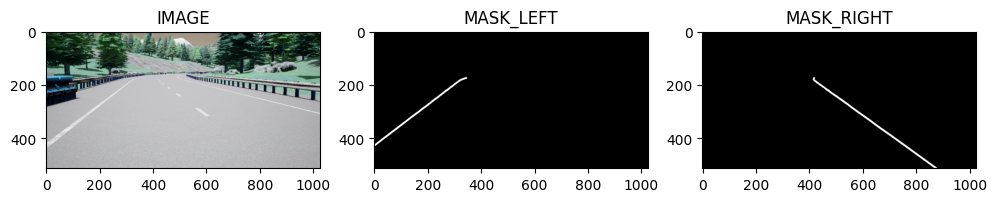

In [10]:
img = cv2.imread(os.path.join(image_dir, os.listdir(image_dir)[0]))
mask_l = cv2.imread(os.path.join(mask_dir_l, os.listdir(mask_dir_l)[0]))
mask_r = cv2.imread(os.path.join(mask_dir_r, os.listdir(mask_dir_r)[0]))

plt.figure(figsize=(12,2))
plt.subplot(1,3,1)
plt.title('IMAGE')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.title('MASK_LEFT')
plt.imshow(cv2.cvtColor(mask_l, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,3)
plt.title('MASK_RIGHT')
plt.imshow(cv2.cvtColor(mask_r, cv2.COLOR_BGR2RGB))

### 3. Object Detection
### 3-1. Training

* TODO : 경로 이동 (project_adas root로 이동)

In [ ]:
cd

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s.yaml')
results = model.train(data ='car_detection.yaml', epochs = 200, batch=16,device = 0  , patience=30, name='car_detection_s')

### 3-2. Testing (Validation)

* TODO : 경로 이동 (project_adas root로 이동)

In [ ]:
cd 

* TODO : `best_model_path`에 성능 가장 좋은 가중치 경로 넣어주기

In [ ]:
from ultralytics import YOLO

# Load a model
best_model_path = 
model = YOLO(best_model_path)  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered

print("map50-95", metrics.box.map)
print("map50", metrics.box.map50)

### 4. Lane Detection - Semantic Segmentation
### 4-1. Training

* TODO : 경로 이동 (pytorch-nested-unet root로 이동)

In [ ]:
cd

* TODO : --dataset에는 lane,  --name에 lane_segmentation 넣기

In [ ]:
!python train.py --dataset lane --arch NestedUNet --name lane_segmentation --epochs 300 --batch_size 4 --input_w 512 --input_h 256 --optimizer Adam --num_classes 2 --lr 0.00001

### 4-2. Inference

* TODO : 경로 이동 (pytorch-nested-unet root로 이동)

In [ ]:
cd

In [13]:
from PIL import Image
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import archs
import yaml

* TODO : `best_model`에 학습한 가중치 넣기

In [ ]:
best_model = 
yml_path = 'models/lane_segmentation/config.yml'

In [14]:
with open(yml_path) as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
print(data)

{'arch': 'NestedUNet', 'batch_size': 4, 'dataset': 'lane', 'deep_supervision': False, 'early_stopping': -1, 'epochs': 300, 'factor': 0.1, 'gamma': 0.6666666666666666, 'img_ext': '.png', 'input_channels': 3, 'input_h': 256, 'input_w': 512, 'loss': 'BCEDiceLoss', 'lr': 1e-05, 'mask_ext': '.png', 'milestones': '1,2', 'min_lr': 1e-05, 'momentum': 0.9, 'name': 'lane_segmentation', 'nesterov': False, 'num_classes': 2, 'num_workers': 4, 'optimizer': 'Adam', 'patience': 2, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 0.0001}


In [15]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model = archs.__dict__[data['arch']](data['num_classes'],data['input_channels'],data['deep_supervision'])
model = model.to(DEVICE)
model.load_state_dict(torch.load(best_model, map_location=DEVICE))
print("model loaded")

model loaded


* TODO : `test_folder`와 `result_folder` 설정해주기
    * `test_folder` : ${project_adas root}/data/lane/val/images
    * `result_folder` : 결과를 저장하고 싶은 폴더

In [16]:
test_folder = 
result_folder = 

if not os.path.exists(result_folder):
    os.makedirs(result_folder)

test_file_list = os.listdir(test_folder)

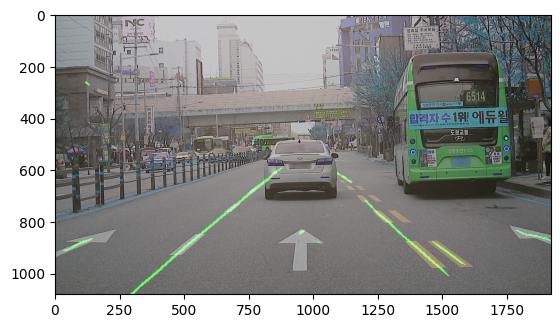

In [17]:
ori_img = cv2.imread(os.path.join(test_folder, test_file_list[8]))
img = cv2.resize(ori_img, (512,256))
input = img.astype('float32') / 255
input = np.expand_dims(input, axis=0)
input = torch.from_numpy(input).to(DEVICE)
input = input.permute(0,3,1,2)
output = model(input)
output = torch.sigmoid(output)
output = output.permute(0,2,3,1).cpu().detach()

pred = np.array(output[0])*255
pred_final = pred[:,:,0] + pred[:,:,1]
pred_final = cv2.resize(pred_final, (ori_img.shape[1], ori_img.shape[0]))
_, pred_final = cv2.threshold(pred_final, 240, 255, cv2.THRESH_BINARY)

lane = np.zeros_like(ori_img)
lane[:,:,1] = pred_final

result = cv2.addWeighted(lane, 0.9, ori_img, 1.0, 0.0)

plt.imshow(result)
plt.show()

### 5. Lane Detection - Hough Transform

### 5-1. 필요한 함수 정의

* TODO : 경로 이동 (project_adas root로 이동)

In [ ]:
cd 

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import math
import collections

In [14]:
def region_of_interest(img, verts):
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # cv2.fillPoly(mask, verts, ignore_mask_color)
    # plt.title('roi mask')
    # plt.imshow(mask, cmap='gray')
    # plt.show()
    
    # line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # cv2.polylines(line_img, verts, isClosed=True, color=[0, 255, 0], thickness=4)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image#, line_img

In [5]:
import collections
prev_left = []
prev_right = []

right_mem = collections.deque(maxlen=10)
left_mem  = collections.deque(maxlen=10)

def average_lines(lines, img):
    '''
    img should be a regioned canny output
    '''
    if lines is None: return lines
    global prev_left, prev_right, right_mem, left_mem

    positive_slopes = []
    positive_xs = []
    positive_ys = []
    negative_slopes = []
    negative_xs = []
    negative_ys = []
    
    min_slope = .3
    max_slope = 1000
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2: continue
            slope = (y2-y1)/(x2-x1)
            
            if abs(slope) < min_slope or abs(slope) > max_slope: continue 
                
            positive_slopes.append(slope) if slope > 0 else negative_slopes.append(slope)
            positive_xs.append(x1) if slope > 0 else negative_xs.append(x1)
            positive_ys.append(y1) if slope > 0 else negative_ys.append(y1)
    
    ysize, xsize = img.shape[0], img.shape[1]
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    white = img == 255
    YY[~white] = ysize*2  
    
    region_top_y = np.amin(YY)
    
    new_lines = []
    if len(positive_slopes) > 0:
        m = np.mean(positive_slopes)
        avg_x = np.mean(positive_xs)
        avg_y = np.mean(positive_ys)
        
        b = avg_y - m*avg_x
        
        x1 = int((region_top_y - b)/m)
        x2 = int((ysize - b)/m)
        prev_left = [(x1, region_top_y, x2, ysize)]

        left_mem.append([(x1, region_top_y, x2, ysize)])
        new_lines.append(np.mean(left_mem,axis=0).astype(int))

    else:
        if(len(left_mem)>0):
            new_lines.append(np.mean(left_mem,axis=0).astype(int))
        
    
    if len(negative_slopes) > 0:
        m = np.mean(negative_slopes)
        avg_x = np.mean(negative_xs)
        avg_y = np.mean(negative_ys)
        
        b = avg_y - m*avg_x
        
        x1 = int((region_top_y - b)/m)
        x2 = int((ysize - b)/m)
        
        prev_right = [(x1, region_top_y, x2, ysize)]
        right_mem.append([(x1, region_top_y, x2, ysize)])
        new_lines.append(np.mean(right_mem, axis=0).astype(int))
    else:
        if(len(prev_right)>0):
            new_lines.append(np.mean(right_mem,axis=0).astype(int))
    
    return np.array(new_lines)

In [6]:
def weighted_img(initial_img, img, a=0.8, b=1., l=0.):
    return cv2.addWeighted(initial_img, a, img, b, l)

In [7]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    if lines is None: return lines
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [8]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    avg_lines = average_lines(lines, img)

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    verts_ = np.array([[ 0,0],[ 0,0],[ 0, 0], [0,0]])
    
    if len(avg_lines)<2:
        return line_img, verts_
    
    if avg_lines[0][0][0] < avg_lines[1][0][0]:
        return line_img, verts_
    
    draw_lines(line_img, avg_lines, color=[0,255,0])
    
    if(avg_lines is not None):
        if(len(avg_lines)>1):
            avg_lines = np.concatenate(avg_lines).ravel().tolist()

    if(avg_lines is not None):
        if(len(avg_lines)>6):
            verts_ = np.array([[avg_lines[0],avg_lines[1]],
                       [avg_lines[4],avg_lines[5]],
                       [avg_lines[6],avg_lines[7]],
                       [avg_lines[2],avg_lines[3]]])
        
            poly_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
            cv2.fillPoly(poly_img, pts = [verts_], color = (0,255,0))
            line_img = weighted_img(line_img,poly_img,a=1.0, b=.2, l=0.)
            
    return line_img, verts_

### 5-2. Linde Detection Function
1. gray scale
2. Blur 처리
    * gaussian blur kernel_size 5
3. canny edge 검출
    * (low 50, high 150)
4. ROI 설정
    * ((0,ysize),(2.4*xsize/5, 1.22*ysize/2), (2.6*xsize/5, 1.22*ysize/2), (xsize,ysize)])
5. Line Detection
    * hough line
6. Line 시각화

In [15]:
def draw_road_line(src, ksize = 5, canny_th = (50, 150), rho = 2 ):
    # 1. gray scale
    gray_img = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    # 2. Blur 처리
    gray_blur = cv2.GaussianBlur(gray_img, (ksize, ksize), 0)
    
    # 3. Edge Detection
    edge_img = cv2.Canny(gray_blur, canny_th[0], canny_th[1])
    
    # 4. ROI 설정
    height, width = gray_img.shape[0], gray_img.shape[1]
    verticies = [(0,height),(2.4*width/5, 1.22*height/2), (2.6*width/5, 1.22*height/2), (width,height)]
    verts = np.array([verticies], dtype=np.int32)
    masked_image = region_of_interest(edge_img, verts)
    
    # 5. Line Detection
    rho = 2
    theta = 3*np.pi/180
    min_line_length = width//16
    max_line_gap = min_line_length//2
    threshold = min_line_length//4
    lines, VERTS = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    # plt.title('roi mask')
    # plt.imshow(masked_image)
    # plt.show()
    
    # plt.title('line detection result')
    # plt.imshow(lines)
    # plt.show()
    
    
    # 6. Line 시각화
    result = cv2.addWeighted(lines, 0.8, src, 1.0, 0.0)
    return result

### 5-3. Test

* TODO : `test_img_path`에 ${project_adas root}/data/lane/val/images의 이미지중 하나의 경로 넣어주기;

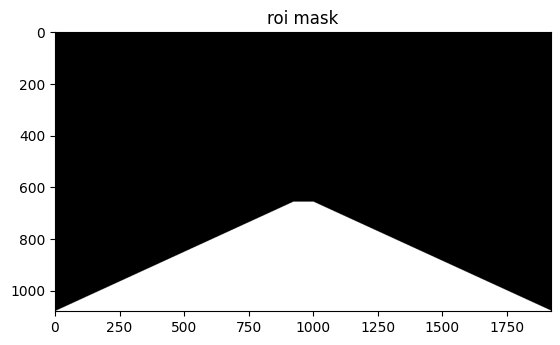

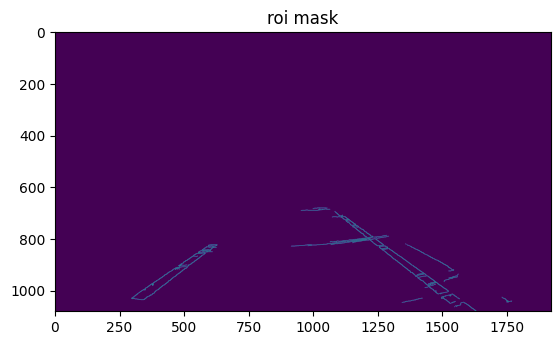

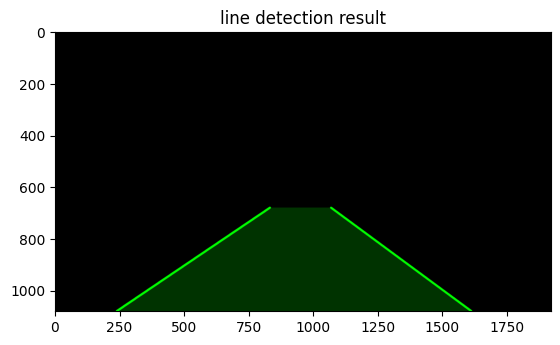

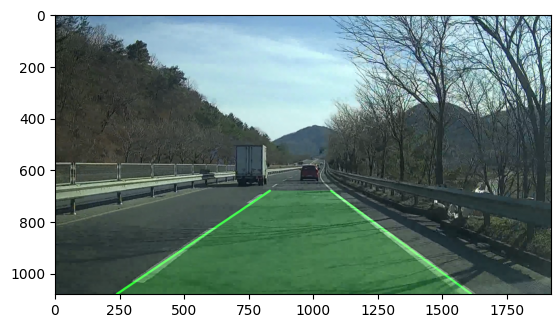

In [16]:
prev_left = []
prev_right = []

right_mem = collections.deque(maxlen=10)
left_mem  = collections.deque(maxlen=10)
img = cv2.imread('20201226_dg_front_0037370.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = draw_road_line(img)

plt.imshow(result)
plt.show()

### 6. Inference
### 6-1. Object Detection + Lane Detection(Hough Transform)

* TODO : 경로 이동 (project_adas root로 이동)

In [ ]:
cd 

In [34]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math
import collections
from ultralytics import YOLO
import cv2
import os
from ultralytics.yolo.utils.plotting import Annotator
import matplotlib.pyplot as plt
import ultralytics

In [35]:
ultralytics.checks()

Ultralytics YOLOv8.0.157  Python-3.8.17 torch-1.7.1+cu110 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
Setup complete  (12 CPUs, 15.8 GB RAM, 610.9/975.9 GB disk)


In [40]:
color_dict = {'car':(255,0,0), 'pedestrian':(0, 0, 255)}
test_folder = 'test_img'
save_folder = 'result'

if not os.path.exists(save_folder):
    os.mkdir(save_folder)

model = YOLO('best_car_detection.pt')


0: 384x640 7 cars, 1 pedestrian, 22.9ms
Speed: 4.0ms preprocess, 22.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 2 pedestrians, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 1 pedestrian, 16.0ms
Speed: 6.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


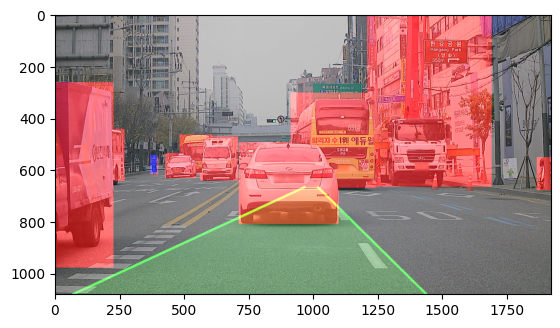


0: 384x640 7 cars, 1 pedestrian, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 pedestrian, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 4 pedestrians, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 7 pedestrians, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 3 pedestrians, 15.0ms
Speed: 4.0ms preprocess, 15.0ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 3 pedestrians, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1 pedestrian, 16.0ms
Speed: 6.0ms preprocess, 16.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 10.0ms
Spe

In [41]:
file_list = os.listdir(test_folder)
for idx, file in enumerate(file_list):

      prev_left = []
      prev_right = []
      right_mem = collections.deque(maxlen=100)
      left_mem  = collections.deque(maxlen=100)

      img = cv2.imread(os.path.join(test_folder, file))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
      results = model(img)
      lane_img = draw_road_line(img)

      black_img = np.zeros_like(lane_img)
      warning_status = False
      
      for result in results:
            annotator = Annotator(img)
            boxes = result.boxes
            for box in boxes:
                  b = box.xyxy[0]
                  cls = int(box.cls)
                  p_start, p_end = (int(b[0]), int(b[1])), (int(b[2]), int(b[3]))
                  cv2.rectangle(black_img, p_start, p_end, color = color_dict[model.names[cls]], thickness=-1)
                  if int(b[3]) > black_img.shape[0]*0.95:
                         warning_status = True
      final_result = cv2.addWeighted(black_img, 0.6, lane_img, 1.0, 0.0)
      if warning_status:
         cv2.rectangle(final_result, (0,0), (600, 140), (255,0,0), -1, cv2.LINE_AA)  # filled
         cv2.putText(final_result, 'Warning!', (0,100),cv2.FONT_HERSHEY_DUPLEX, 4,(255,255,255), thickness=3, lineType=cv2.LINE_AA)

      cv2.imwrite(os.path.join('result', file), cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))

      plt.imshow(final_result)
      plt.show()

### 6-2. Object Detection + Lane Detection(Semantic Segmentation)

* TODO : 경로 이동 (pytorch-nested-unet root로 이동)

In [ ]:
cd

In [27]:
from PIL import Image
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import archs
import yaml

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
import ultralytics

In [28]:
ultralytics.checks()

Ultralytics YOLOv8.0.145  Python-3.7.16 torch-1.7.1+cu110 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
Setup complete  (12 CPUs, 15.8 GB RAM, 593.2/975.9 GB disk)


* TODO : 경로 설정
    * pjt_folder : project_adas 루트폴더로
    * od_model : yolo모델 학습 가중치중 가장 좋은 것을 project_adas 루프폴더로 이동하고, 해당 파일의 이름
    * ss_model : unet++모델 학습 가중치 중 가장 좋은 것의 경로

In [31]:
pjt_folder = 
od_model = 
ss_model = 
yml_path = 'models/lane_segmentation/config.yml'

color_dict = {'car':(255,0,0), 'pedestrian':(0, 0, 255)}
test_folder = os.path.join(pjt_folder,'test_img')
save_folder = os.path.join(pjt_folder,'result_unet')

if not os.path.exists(save_folder):
    os.mkdir(save_folder)

with open(yml_path) as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
print(data)

{'arch': 'NestedUNet', 'batch_size': 4, 'dataset': 'lane', 'deep_supervision': False, 'early_stopping': -1, 'epochs': 300, 'factor': 0.1, 'gamma': 0.6666666666666666, 'img_ext': '.png', 'input_channels': 3, 'input_h': 256, 'input_w': 512, 'loss': 'BCEDiceLoss', 'lr': 1e-05, 'mask_ext': '.png', 'milestones': '1,2', 'min_lr': 1e-05, 'momentum': 0.9, 'name': 'lane_segmentation', 'nesterov': False, 'num_classes': 2, 'num_workers': 4, 'optimizer': 'Adam', 'patience': 2, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 0.0001}


In [32]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = archs.__dict__[data['arch']](data['num_classes'],data['input_channels'],data['deep_supervision'])
model = model.to(DEVICE)
model.load_state_dict(torch.load(best_model, map_location=DEVICE))
print("segmentation model loaded")

yolo_model = YOLO(os.path.join(pjt_folder, od_model))
print('Yolo Model Loaded')

segmentation model loaded
Yolo Model Loaded


* TODO : 경로 지정
    * `test_folder` : ${project_adas root}/data/lane/val/images의 
    * `result_folder` : ex.  ${project_adas root}/result

In [48]:
test_folder = 
result_folder = 

if not os.path.exists(result_folder):
    os.makedirs(result_folder)

In [53]:
def draw_lane(ori_img, model):
    img = cv2.resize(ori_img, (512,256))
    input = img.astype('float32') / 255
    input = np.expand_dims(input, axis=0)
    input = torch.from_numpy(input).to(DEVICE)
    input = input.permute(0,3,1,2)
    output = model(input)
    output = torch.sigmoid(output)
    output = output.permute(0,2,3,1).cpu().detach()

    pred = np.array(output[0])*255
    pred_final = pred[:,:,0] + pred[:,:,1]
    pred_final = cv2.resize(pred_final, (ori_img.shape[1], ori_img.shape[0]))
    _, pred_final = cv2.threshold(pred_final, 250, 255, cv2.THRESH_BINARY)

    lane = np.zeros_like(ori_img)
    lane[:,:,1] = pred_final
    result = cv2.addWeighted(lane, 0.9, ori_img, 1.0, 0.0)
    return result

0: 384x640 6 cars, 5 pedestrians, 15.0ms
Speed: 7.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


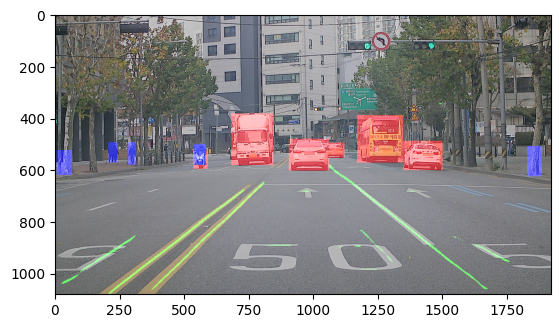


0: 384x640 7 cars, 1 pedestrian, 15.0ms
Speed: 3.0ms preprocess, 15.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


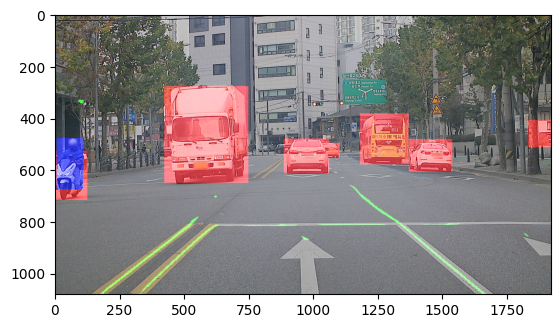


0: 384x640 5 cars, 2 pedestrians, 14.9ms
Speed: 3.0ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


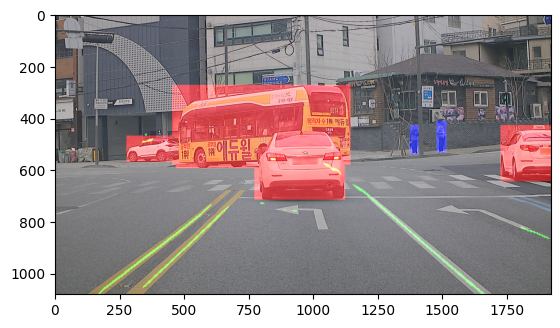


0: 384x640 3 cars, 2 pedestrians, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


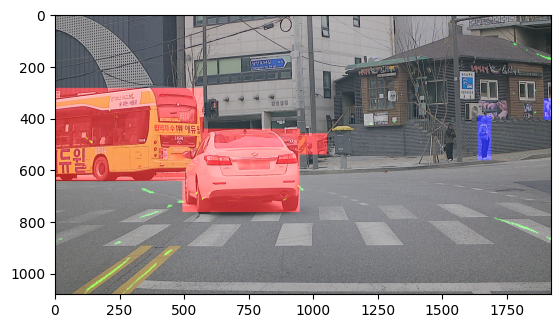


0: 384x640 3 cars, 1 pedestrian, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


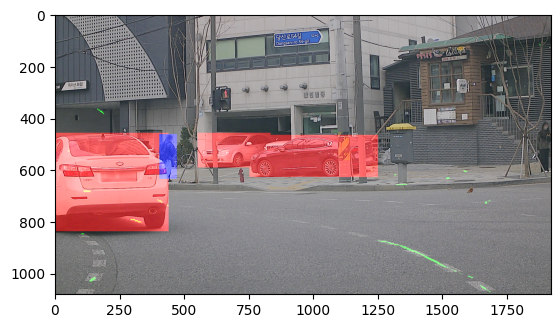


0: 384x640 3 cars, 1 pedestrian, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


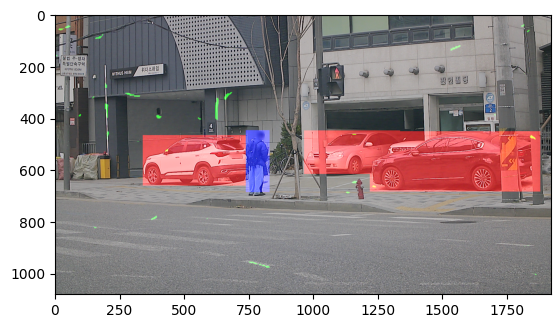


0: 384x640 7 cars, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


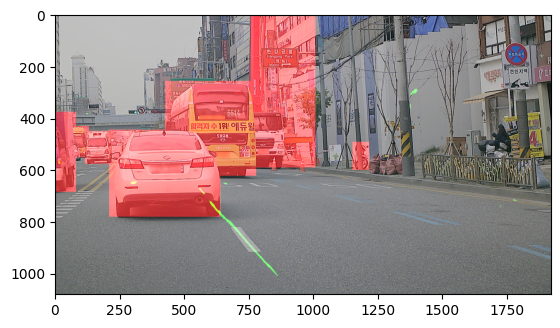


0: 384x640 10 cars, 1 pedestrian, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


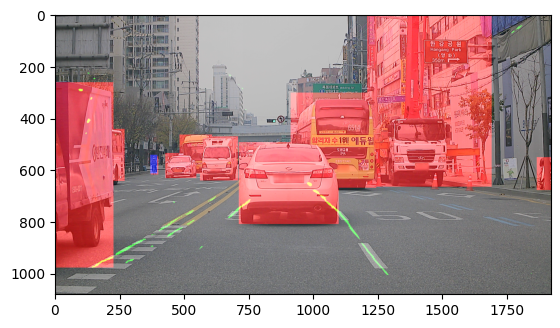


0: 384x640 7 cars, 1 pedestrian, 12.0ms
Speed: 4.0ms preprocess, 12.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


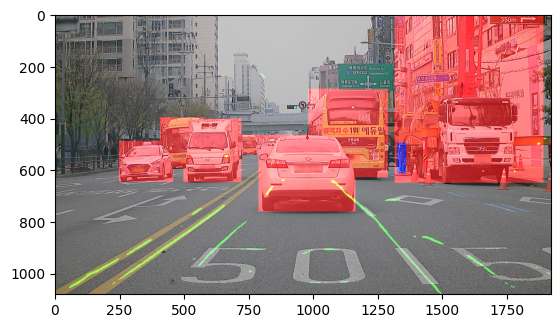


0: 384x640 9 cars, 1 pedestrian, 8.9ms
Speed: 6.0ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


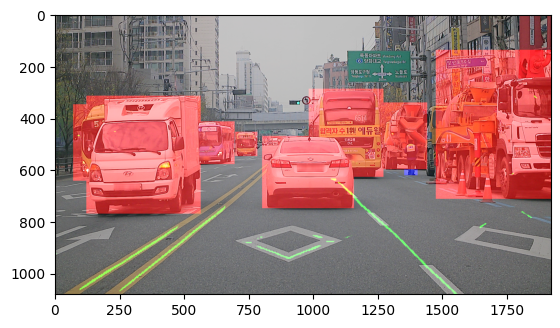


0: 384x640 7 cars, 2 pedestrians, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 pedestrian, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 8 pedestrians, 15.0ms
Speed: 4.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 4 pedestrians, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 7 pedestrians, 13.0ms
Speed: 3.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 7 pedestrians, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 3 pedestrians, 10.0ms
Speed: 4.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 3 pedestrians,

In [54]:
file_list = os.listdir(test_folder)
for idx, file in enumerate(file_list):
    ori_img = cv2.imread(os.path.join(test_folder, file))
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    
    result_lane = draw_lane(ori_img, model)

    results = yolo_model(ori_img)
    black_img = np.zeros_like(result_lane)
    warning_status = False

    for result in results:
        annotator = Annotator(ori_img)
        boxes = result.boxes
        for box in boxes:
                b = box.xyxy[0]
                cls = int(box.cls)
                p_start, p_end = (int(b[0]), int(b[1])), (int(b[2]), int(b[3]))
                cv2.rectangle(black_img, p_start, p_end, color = color_dict[yolo_model.names[cls]], thickness=-1)
                if int(b[3]) > black_img.shape[0]*0.95:
                        warning_status = True
    final_result = cv2.addWeighted(black_img, 0.6, result_lane, 1.0, 0.0)
    if warning_status:
        cv2.rectangle(final_result, (0,0), (600, 140), (255,0,0), -1, cv2.LINE_AA)  # filled
        cv2.putText(final_result, 'Warning!', (0,100),cv2.FONT_HERSHEY_DUPLEX, 4,(255,255,255), thickness=3, lineType=cv2.LINE_AA)


    if idx <10:
        plt.imshow(final_result)
        plt.show()

    cv2.imwrite(os.path.join(result_folder, file), cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))